#### Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, f1_score, precision_recall_curve, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split, GridSearchCV,  StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
import joblib
warnings.filterwarnings("ignore")

In [2]:
# Preprocessing (Done in Data Exploration)
df=pd.read_csv('df_com_6500.csv',low_memory=False)
df['death'].fillna(0, inplace=True) # Replacing NaN values in death with 0 (its better than dropping the value to mark them as false negative)
df['IFNA21'].fillna((df['IFNA21'].mean()), inplace=True) # Replacing NaN values in IFNA21, ANKRD7, UGT2B17 columns with their own means
df['ANKRD7'].fillna((df['ANKRD7'].mean()), inplace=True)
df['UGT2B17'].fillna((df['UGT2B17'].mean()), inplace=True)

#### Extraction

In [3]:
X = df.drop(["death","aging","sex"], axis=1) 
y = df.death

In [4]:
df['death'].value_counts()

death
0.0    948
1.0    349
Name: count, dtype: int64

In [4]:
target_count = max(y.value_counts())
smote = SMOTE(sampling_strategy={0: target_count, 1: target_count}, random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

In [5]:
print("Original dataset shape:", Counter(y))
print("SMOTE resampled dataset shape:", Counter(y_resampled_smote))
X,y= X_resampled_smote, y_resampled_smote


Original dataset shape: Counter({0.0: 948, 1.0: 349})
SMOTE resampled dataset shape: Counter({0.0: 948, 1.0: 948})


In [7]:
X.shape

(1896, 6594)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

In [7]:
result=pd.DataFrame(columns=["Model","Accuracy", "Balanced Accuracy","F1","Recall","Precision","ROC-AUC","Confusion Matrix"])

def metrics(model,name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    matrix= confusion_matrix(y_test, y_pred)
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        if hasattr(model, 'decision_function'):
            decision_scores = model.decision_function(X_test)
            y_probs = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
        else:
            raise AttributeError(f"{name} does not have predict_proba or decision_function")
    roc_auc = roc_auc_score(y_test, y_probs)
    
    cmd = ConfusionMatrixDisplay(matrix, display_labels=['survive', "death"]) 
    cmd.plot(cmap='Wistia'); 
    result.loc[len(result)] = [name, accuracy, balanced_accuracy, f1, recall, precision,roc_auc, matrix.tolist()] 
    return result


#### Logistic Regression

##### Grid Searching

In [8]:
grid = [
    {'solver': ['newton-cg', 'lbfgs'], 'penalty': ['l2'], 'C': np.logspace(-1, 2, 3)},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': np.logspace(-1, 2, 3)},
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': np.logspace(-1, 2, 3), 'l1_ratio': [0.5, 1.0]}
]

cv = StratifiedKFold(n_splits=5)
gridsearch=GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=grid, cv=cv, scoring = "f1")
gridsearch.fit(X,y)
params = gridsearch.best_params_

##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.9,0.802817,0.904155,"[[148, 42], [19, 171]]"


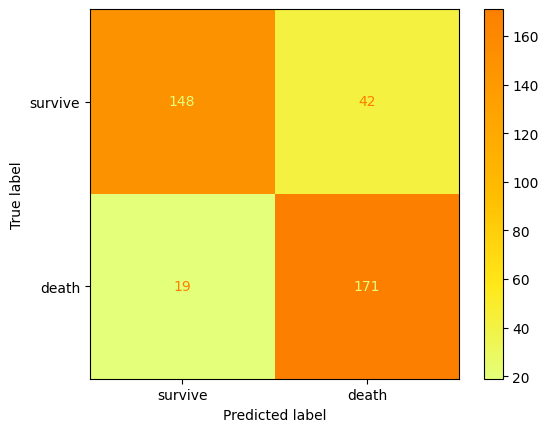

In [8]:
params= {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
logreg = LogisticRegression(**params)
logreg.fit(X_train, y_train)
metrics(logreg,'LR')

####    Random Forest


##### Grid Searching

In [15]:
grid = {
    'bootstrap': [True],
    'max_depth': [ 90, 100,110,120,130,140],
    'max_features': [5,6,7,8],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [10,12,14],
    'n_estimators': [30,40,50, 60, 70,]
}
cv = StratifiedKFold(n_splits=5)
gridsearch=GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv=cv, scoring = "f1",n_jobs = -1)
gridsearch.fit(X,y)
params = gridsearch.best_params_

##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"


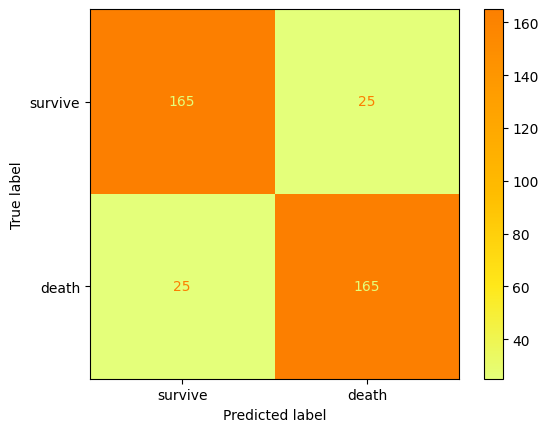

In [9]:
# print(params)
params= {'bootstrap': True, 'max_depth': 130, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 40}
RF = RandomForestClassifier(**params)
RF.fit(X_train, y_train)
metrics(RF,'RF')

#### Bagging

##### Grid Search

In [ ]:
# pip install scikit-learn==1.2.2

In [17]:
grid={'n_estimators': [10, 100,1000]}
cv = StratifiedKFold(n_splits=5)
bg=BaggingClassifier(estimator=DecisionTreeClassifier())
grid_search = GridSearchCV(estimator=bg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X, y)
params = grid_search.best_params_

##### Model Training 

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"


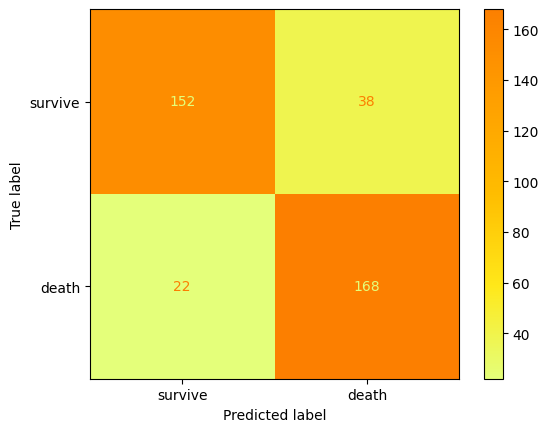

In [10]:
# print(params)
params={'n_estimators': 10}
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(),**params)
bagging.fit(X_train, y_train)
metrics(bagging,'Bagging')

#### XGB

##### Grid Searching

In [19]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
grid = {
    'max_depth': range (4, 7, 1),
    'n_estimators': range(160, 220, 20),
    'learning_rate': [0.1, 0.01]
}
gridsearch = GridSearchCV(estimator=estimator, param_grid=grid,scoring = 'f1', n_jobs = 8,  cv=5, verbose=True)
gridsearch.fit(X,y)
params = gridsearch.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"
3,XGB,0.894737,0.894737,0.897959,0.926316,0.871287,0.959003,"[[164, 26], [14, 176]]"


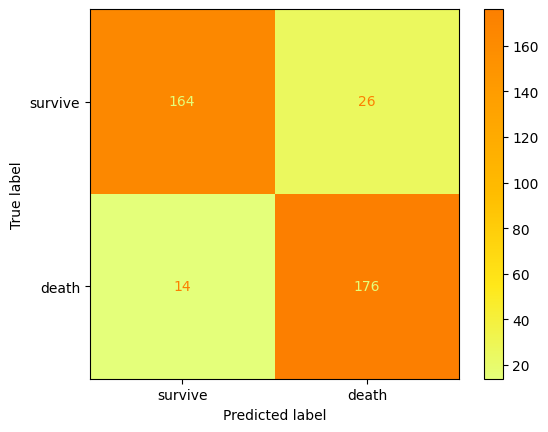

In [11]:
# print(params)
params={'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 180}
XGB = XGBClassifier(**params)
XGB.fit(X_train, y_train)
metrics(XGB,'XGB')

#### LightGBM

##### Grid Searching

In [21]:
grid = {
    'n_estimators': [80,90,100],           
    'learning_rate': [0.2,0.3,0.4],        
    'max_depth': [4, 5],                       
    'num_leaves': [10,12],
    'subsample': [0.2],            
    'colsample_bytree': [0.9,1.0,1.1]
}
lgb_classifier = lgb.LGBMClassifier(force_col_wise=True)
gridsearch = GridSearchCV(estimator=lgb_classifier, param_grid=grid, cv=5, scoring='accuracy', n_jobs=8)
gridsearch.fit(X,y)
params = gridsearch.best_params_

[LightGBM] [Info] Number of positive: 948, number of negative: 948
[LightGBM] [Info] Total Bins 1681469
[LightGBM] [Info] Number of data points in the train set: 1896, number of used features: 6594
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"
3,XGB,0.894737,0.894737,0.897959,0.926316,0.871287,0.959003,"[[164, 26], [14, 176]]"
4,LGB,0.831579,0.831579,0.837563,0.868421,0.808824,0.898892,"[[151, 39], [25, 165]]"


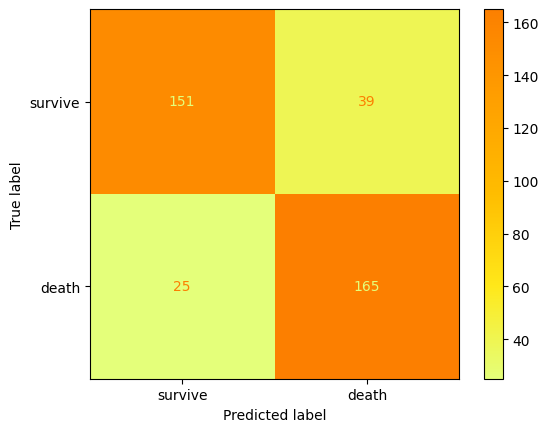

In [12]:
# print(params)
params={'colsample_bytree': 0.9, 'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 80, 'num_leaves': 10, 'subsample': 0.2}

lgb_classifier = XGBClassifier(**params)
lgb_classifier.fit(X_train, y_train)
metrics(lgb_classifier,'LGB')

#### KNN

##### Grid Search

In [25]:

grid = {
    'n_neighbors' : range(2, 21, 2),
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
    }
gridsearch = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
gridsearch.fit(X,y)
params = gridsearch.best_params_

##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"
3,XGB,0.894737,0.894737,0.897959,0.926316,0.871287,0.959003,"[[164, 26], [14, 176]]"
4,LGB,0.831579,0.831579,0.837563,0.868421,0.808824,0.898892,"[[151, 39], [25, 165]]"
5,KNN,0.807895,0.807895,0.828235,0.926316,0.748936,0.820623,"[[131, 59], [14, 176]]"


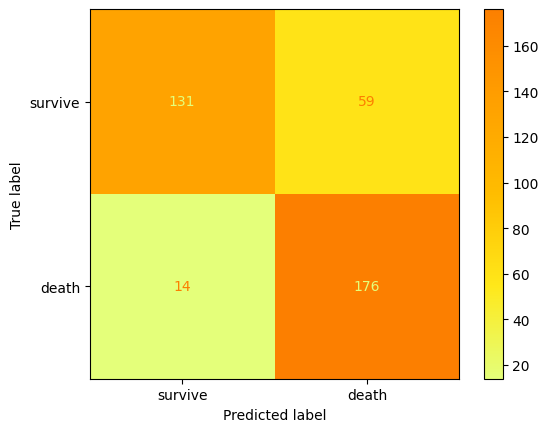

In [13]:
# print(params)
params={'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}
KNN = KNeighborsClassifier(**params)
KNN.fit(X_train, y_train)
metrics(KNN,'KNN')

#### SVC

##### Grid Search

In [27]:
grid = {
    'kernel': ['linear','poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-3,3,7)
    }
gridsearch = GridSearchCV(estimator=SVC(), param_grid=grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
gridsearch.fit(X,y)
params = gridsearch.best_params_

##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"
3,XGB,0.894737,0.894737,0.897959,0.926316,0.871287,0.959003,"[[164, 26], [14, 176]]"
4,LGB,0.831579,0.831579,0.837563,0.868421,0.808824,0.898892,"[[151, 39], [25, 165]]"
5,KNN,0.807895,0.807895,0.828235,0.926316,0.748936,0.820623,"[[131, 59], [14, 176]]"
6,SVC,0.910526,0.910526,0.915423,0.968421,0.867925,0.982188,"[[162, 28], [6, 184]]"


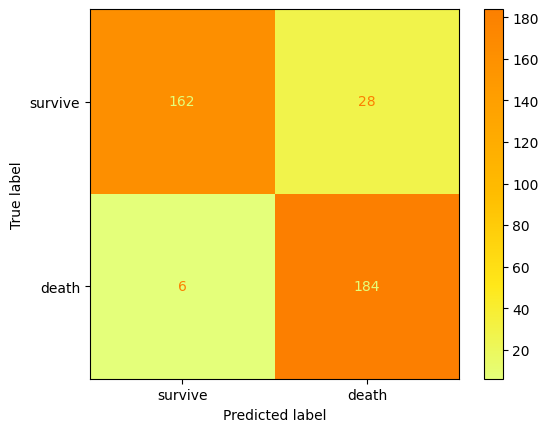

In [14]:
# print(params)
params={'C': 1000.0, 'kernel': 'rbf'}
SVCClassifier = SVC(**params,probability=True)
SVCClassifier.fit(X_train, y_train)
metrics(SVCClassifier,'SVC') 

#### Gaussian NB

##### Grid Search

In [29]:
grid= {'var_smoothing': np.logspace(0,-10, num=30)}
grid_search = GridSearchCV(estimator=GaussianNB(),param_grid=grid,cv=StratifiedKFold(n_splits=5),verbose=1,scoring='accuracy') 
grid_search.fit(X, y)
params = grid_search.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"
3,XGB,0.894737,0.894737,0.897959,0.926316,0.871287,0.959003,"[[164, 26], [14, 176]]"
4,LGB,0.831579,0.831579,0.837563,0.868421,0.808824,0.898892,"[[151, 39], [25, 165]]"
5,KNN,0.807895,0.807895,0.828235,0.926316,0.748936,0.820623,"[[131, 59], [14, 176]]"
6,SVC,0.910526,0.910526,0.915423,0.968421,0.867925,0.982188,"[[162, 28], [6, 184]]"
7,GNB,0.584211,0.584211,0.644144,0.752632,0.562992,0.587285,"[[79, 111], [47, 143]]"


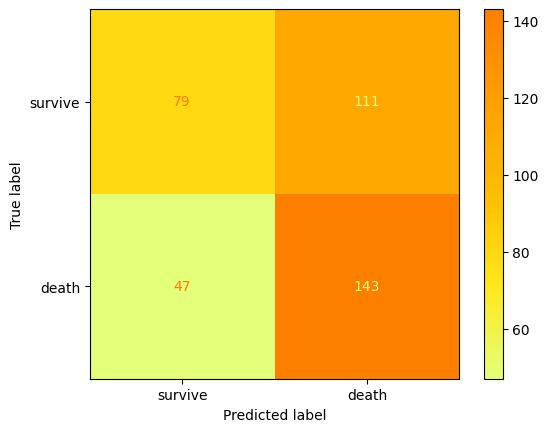

In [15]:
# print(params)
params= {'var_smoothing': 0.4520353656360243}
GNB = GaussianNB(**params)
GNB.fit(X_train, y_train)
metrics(GNB,'GNB') 

#### Stacking

##### Model Training

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"
3,XGB,0.894737,0.894737,0.897959,0.926316,0.871287,0.959003,"[[164, 26], [14, 176]]"
4,LGB,0.831579,0.831579,0.837563,0.868421,0.808824,0.898892,"[[151, 39], [25, 165]]"
5,KNN,0.807895,0.807895,0.828235,0.926316,0.748936,0.820623,"[[131, 59], [14, 176]]"
6,SVC,0.910526,0.910526,0.915423,0.968421,0.867925,0.982188,"[[162, 28], [6, 184]]"
7,GNB,0.584211,0.584211,0.644144,0.752632,0.562992,0.587285,"[[79, 111], [47, 143]]"
8,Stacking,0.931579,0.931579,0.932642,0.947368,0.918367,0.983158,"[[174, 16], [10, 180]]"


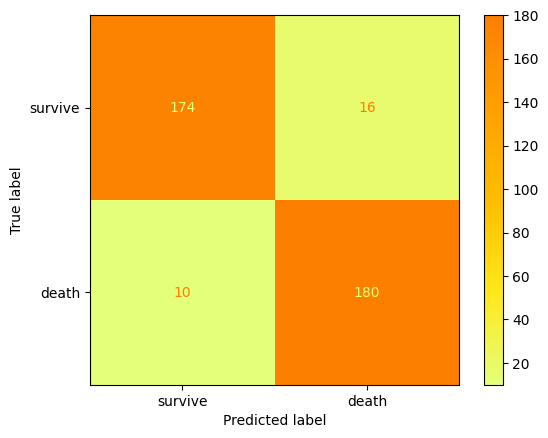

In [16]:
level0 = list()
level0.append(('LogReg', logreg))
level0.append(('RF', RF))
level0.append(('XGB', XGB))
level0.append(('LGB', lgb_classifier))
level0.append(('KNN',KNN))
level0.append(('SVC', SVCClassifier))
level0.append(('GNB', GNB))
level1 = LogisticRegression(solver='liblinear')

stack = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
stack.fit(X_train, y_train)
metrics(stack,'Stacking')

#### Saving Models

In [19]:
import joblib
joblib.dump(logreg, 'oversampled/logreg_model.pkl')
joblib.dump(RF, 'oversampled/RF_model.pkl')
joblib.dump(XGB, 'oversampled/XGB_model.pkl')
joblib.dump(lgb_classifier, 'oversampled/lgb_classifier_model.pkl')
joblib.dump(KNN, 'oversampled/KNN_model.pkl')
joblib.dump(SVCClassifier, 'oversampled/SVCClassifier_model.pkl')
joblib.dump(GNB, 'oversampled/GNB_model.pkl')
joblib.dump(stack, 'oversampled/stack_model.pkl')
joblib.dump(bagging, 'regular/bagging_model.pkl')


['regular/bagging_model.pkl']

#### Loading Models

In [ ]:
logreg = joblib.load('oversampled/logreg_model.pkl')
RF = joblib.load('oversampled/RF_model.pkl')
XGB = joblib.load('oversampled/XGB_model.pkl')
lgb_classifier = joblib.load('oversampled/lgb_classifier_model.pkl')
KNN = joblib.load('oversampled/KNN_model.pkl')
SVCClassifier = joblib.load('oversampled/SVCClassifier_model.pkl')
GNB = joblib.load('oversampled/GNB_model.pkl')
stack = joblib.load('oversampled/stack_model.pkl')
bagging = joblib.load('oversampled/bagging_model.pkl')

#### Result Analysis

In [17]:
result

,Model,Accuracy,Balanced Accuracy,F1,Recall,Precision,ROC-AUC,Confusion Matrix
0,LR,0.839474,0.839474,0.848635,0.900000,0.802817,0.904155,"[[148, 42], [19, 171]]"
1,RF,0.868421,0.868421,0.868421,0.868421,0.868421,0.924515,"[[165, 25], [25, 165]]"
2,Bagging,0.842105,0.842105,0.848485,0.884211,0.815534,0.928781,"[[152, 38], [22, 168]]"
3,XGB,0.894737,0.894737,0.897959,0.926316,0.871287,0.959003,"[[164, 26], [14, 176]]"
4,LGB,0.831579,0.831579,0.837563,0.868421,0.808824,0.898892,"[[151, 39], [25, 165]]"
5,KNN,0.807895,0.807895,0.828235,0.926316,0.748936,0.820623,"[[131, 59], [14, 176]]"
6,SVC,0.910526,0.910526,0.915423,0.968421,0.867925,0.982188,"[[162, 28], [6, 184]]"
7,GNB,0.584211,0.584211,0.644144,0.752632,0.562992,0.587285,"[[79, 111], [47, 143]]"
8,Stacking,0.931579,0.931579,0.932642,0.947368,0.918367,0.983158,"[[174, 16], [10, 180]]"


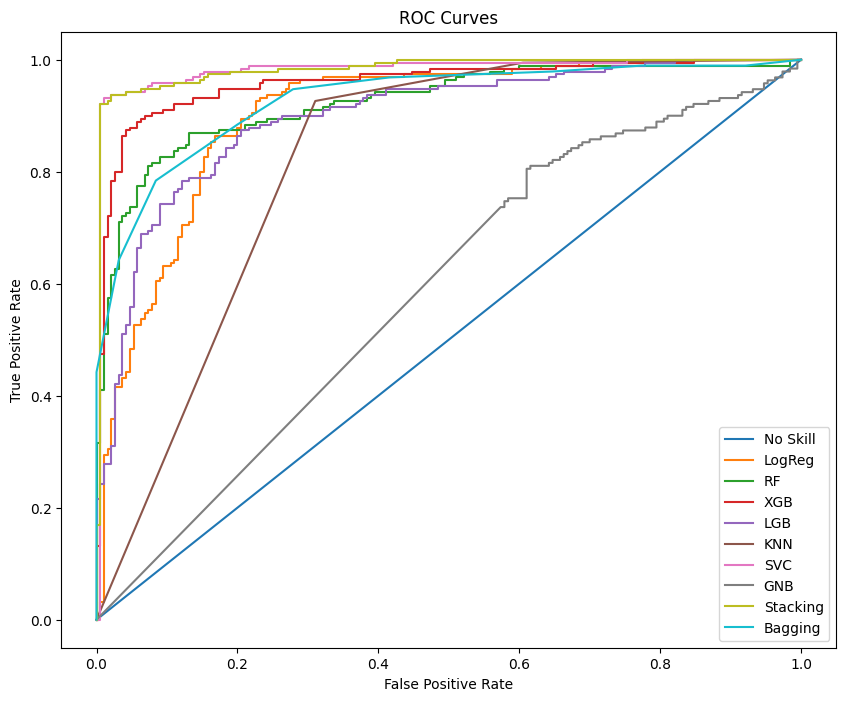

In [18]:
def get_roc_auc_scores_and_curves(models, X_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)    
    roc_data = {'No Skill': (ns_fpr, ns_tpr)}
    
    for name, model in models:
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X_test)[:, 1]
        else:
            if hasattr(model, 'decision_function'):
                decision_scores = model.decision_function(X_test)
                probs = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
            else:
                raise AttributeError(f"{name} does not have predict_proba or decision_function")
        
        auc = roc_auc_score(y_test, probs)
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_data[name] = (fpr, tpr)
    
    return roc_data

models = level0 + [('Stacking', stack),('Bagging',bagging)]
roc_data = get_roc_auc_scores_and_curves(models, X_test, y_test)
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=model_name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()